# Predecir Skill en LinkedIN

Para esta sección se trabaja con un dataset que consta de las habilidades/capacidades/competencias (skill) declaradas por distintos usuarios en el sitio web LinkedIN, trabajando con una matriz dispersa (<i>sparse matrix</i>) debido a la gran cantidad de valores nulos (competencias no declaradas), esto agiliza los procesos de ajustar el modelo de cada clasificador.

### A)

In [17]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.io import mmread

def cargar_archivo(arch):
    f = open(arch,'r')
    lines= f.readlines()
    M = [ line.replace(":",',').replace("\n","").split(',') for line in lines]
    
    lista_sparse = []
    for usuario in M:
        user_id = usuario.pop(0)
        for skill in usuario:
            lista_sparse.append([int(user_id),int(skill),1])
            
    rows,cols,data = zip(*lista_sparse)
    return csr_matrix((data, (rows, cols)))

import re,codecs
def cargar_skills(arch,d):
    skills = ['None' for i in range(d)]  
    f = codecs.open(arch,'r',encoding="utf-8")
    lines= f.readlines()
    M = [ re.split(':(\d+)',line.strip('\n')) for line in lines]
    for datos_skill in M:
        if(datos_skill[0] == ""):
            skills[int(datos_skill[1])] = "Otros*"
        else:
            skills[int(datos_skill[1])] = datos_skill[0]
    return skills

dt_userskill = cargar_archivo('user_skill')
n ,d = dt_userskill.shape 
lista_skills =  cargar_skills('skill_id',d)
#print lista_skills
print dt_userskill.shape

(7890, 14544)


En el código anterior se carga el archivo <b>user_skill</b> donde estan presentes los datos y se convierten en una matriz $sparse$ (dispersa), en la cual las filas representan a los usuarios y las columnas a las <i>skill</i> de cada usuario correspondiente, llenando los valores de la matriz con 0 o 1, si declara o no competencia. Por ejemplo si el usuario $i$ declara la competencia $j$ habrá un 1 en la posición ($i$,$j$) en la matriz <i>dt_userskill</i>. También son cargados los nombres de cada competencia desde el archivo <b>skill_id</b> a una lista <i>lista_skills</i>.

### B)

In [40]:
n = 7890 #number of users
d = 14544 #number of skills

#from random import randint
#print randint(10,50) #porciento de test set = 34 %
index = np.arange(np.shape(dt_userskill)[0]) #filas 
np.random.shuffle(index) #permutan las filas
Z = dt_userskill[index, :] #matriz permutada

l =  int(n*.34)
Z_tr = Z[l:,] #Datos de entrenamiento (76%)
print Z_tr.shape
Z_ts = Z[:l,] #Datos de prueba (34%)
print Z_ts.shape

(5208, 14544)
(2682, 14544)


En la celda anterior se crean, a partir del dataset original <i>Z</i>, dos dataset, uno de prueba y otro de entrenamiento ($Z_{ts}$ y $Z_{tr}$ respectivamente), donde son separados en base las dimensiones $n \times d$ del dataset original ($n$ = 7890), tomando un porcentaje de test set del 34% ($n_{ts}$ = 2682) , quedando 76% del dataset original como el training set ($n_{tr}$ = 5208)

### C)

In [3]:
users_skill = np.zeros(d) #numero de usuarios por skill
for i in range(d): #every skill
    users_skill[i] = dt_userskill.getcol(i).getnnz()

Se genera una lista con la cantidad de usuarios que declara cada $skill$.

------------Mejores------------------


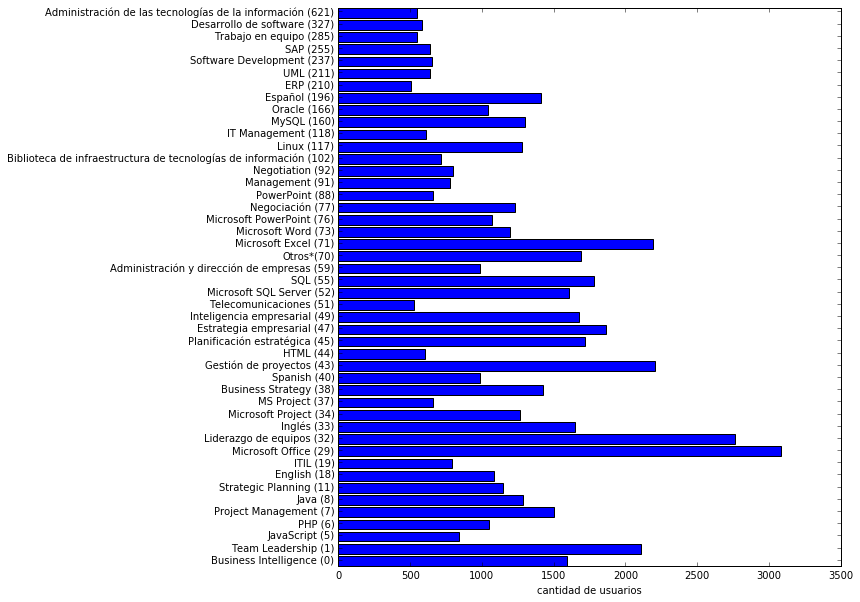

------------Peores------------------
[u'Gamification (20)', u'Process Scheduler (96)', u'Cisco Catalyst Switches (106)', u'Huawei (107)', u'Service Provider Networks (111)', u'NICE (113)', u'Information Systems Strategy (123)', u'Hardware Architecture (125)', u'information systems development (135)', u'Geoinformatics (138)', u'Geomarketing (139)', u'Image Analysis (140)', u'IT Government (142)', u'Eagle PCB (146)', u'Arquitectura Cloud (152)', u'FreeCAD (154)', u'3D Printer Design (155)', u'CNC Design (156)', u'WebMapping (157)', u'Habilidades Computacionales,  Prezi, Office, Snagit, Google Earth, Moodle (163)']


In [38]:
cantidad_mejores = [] #cantidad de usuarios de los mejores skill
id_mejores = [] #id de skill de las mejores
id_peores = []
for i in range(d):
    if users_skill[i] > 500:
        cantidad_mejores.append(users_skill[i])
        id_mejores.append(i)
    if users_skill[i] < 5:
        id_peores.append(i)
#para obtener la concatenacion (nombre + (id))
nombre_mejores = map(lista_skills.__getitem__, id_mejores)
nombre_id = [nombre+ "("+str(id_m)+")" for nombre,id_m in zip(nombre_mejores,id_mejores)]
nombre_peores =  map(lista_skills.__getitem__, id_peores)
nombre_id_peor = [nombre+ "("+str(id_m)+")" for nombre,id_m in zip(nombre_peores,id_peores)]

print "------------Mejores------------------"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,10))
ax.barh(range(len(cantidad_mejores)),cantidad_mejores)
ax.set_yticks(np.arange(0.5,len(cantidad_mejores),1))
ax.set_yticklabels(nombre_id)
ax.set_xlabel("cantidad de usuarios")
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

print "------------Peores------------------"
print nombre_id_peor[:20]

El gráfico anterior muestra a las competencias declaradas con una mayor cantidad de usuarios (mayor a 500 usuarios), mostrando por ejemplo la competencia <i>Linux</i> tiene entre 1000-1500 usuarios. Estas competencias son las que más se declaran en todo el dataset, teniendo valores considerables para el análisis, ya que por ejemplo la competencia <i>Microsoft Office</i> tiene mas de 3000 usuarios, casi la mitad de ejemplos del dataset ($n$ = 7890). 

Se presentan por otro lado las competencias declaradas con la menor cantidad de usuarios (menor a 5 usuarios), es decir estas competencias son declaradas por a lo más 5 usuarios, siendo las que menos se repiten en todo el dataset, llegando a ser despreciables respecto al tamaño del dataset.

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


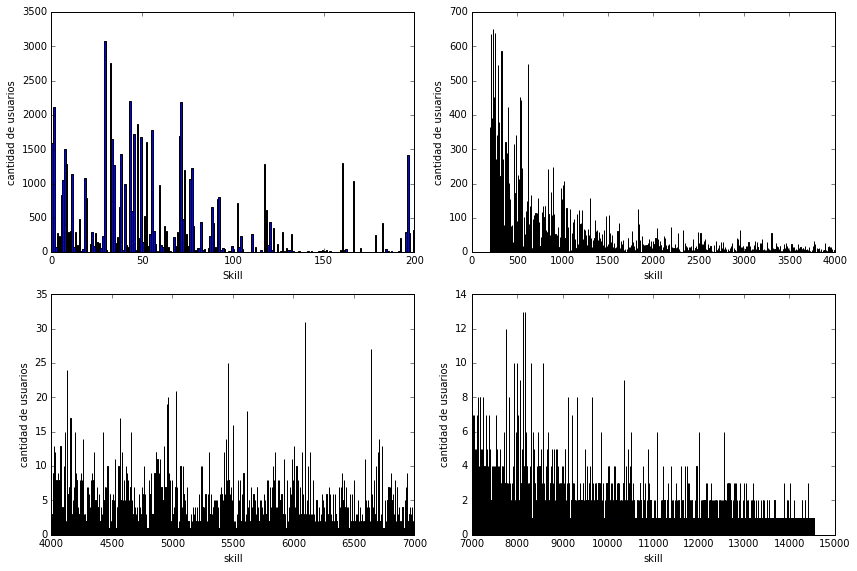

In [39]:
####GRAFICOS-----------------
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr[0, 0].bar(range(200),users_skill[:200])
axarr[0, 0].set_xlabel('Skill')
axarr[0, 0].set_ylabel('cantidad de usuarios')
axarr[0, 0].legend()

axarr[0, 1].bar(range(200,4000),users_skill[200:4000])
axarr[0, 1].set_xlabel('skill')
axarr[0, 1].set_ylabel('cantidad de usuarios')
axarr[0, 1].legend()

axarr[1, 0].bar(range(4000,7000),users_skill[4000:7000])
axarr[1, 0].set_xlabel('skill')
axarr[1, 0].set_ylabel('cantidad de usuarios')
axarr[1, 0].legend(frameon=True)

axarr[1, 1].bar(range(7000,d),users_skill[7000:d])
axarr[1, 1].set_xlabel('skill')
axarr[1, 1].set_ylabel('cantidad de usuarios')
axarr[1, 1].legend(loc='upper right', fancybox=True)

f.tight_layout() #separar los subplot
plt.show()

En los gráficos anteriores se visualiza la cantidad de usuarios que declara cada competencia (skill), a un alto nivel, se puede visualizar que hay una gran cantidad de competencias que no tienen tantos usuarios que la declaren. Desde la competencia de <i>id</i> 4000 en adelante la cantidad de usuarios que declaran esa competencia no superan los 35 usuarios. Esto traducido en la matriz que representa a los datos es tener una gran cantidad de columnas con muchas filas nulas, es decir la matriz tiene muy pocos valores representativos que entregan información.

### D)

In [41]:
j = 0 # columna a predecir
print "competencia a predecir: %s"%(lista_skills[j])
cols = range(d) #lista de columnas
cols.remove(j)

y_tr = Z_tr.getcol(j).toarray().T[0] #target training set
y_ts = Z_ts.getcol(j).toarray().T[0] #target test set

from scipy import sparse
X_tr = sparse.lil_matrix(sparse.csr_matrix(Z_tr)[:,cols])
X_ts = sparse.lil_matrix(sparse.csr_matrix(Z_ts)[:,cols])
print "matrices formadas"

competencia a predecir: Business Intelligence 
matrices formadas


La columna a predecir <i>j</i> es tomada como el target a predecir, con esto se forman los vectores columna $y_{tr}$ y $y_{ts}$. Por otra parte a la matriz con todos los datos se le extrae la columna que se predecirá (target), llegando a tener una dimensión $(n_{x} \times d$-1). El objetivo es predecir la existencia de la competencia $j$ en un perfil a partir de las demás competencias declaradas por el usuario.

### E)

In [44]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "El modelo: %s se ha ajustado con accuracy: %f"%(text,acc_test)
    return [acc_tr,acc_test]

def clasificar_prob(y,yt):
    #AJUSTE
    frecuencia =  np.bincount(y) 
    etiquetas = list(set(y))
    total = float(sum(frecuencia))
    prob = [i/total for i in frecuencia]
    #PREDICT
    np.random.seed(0)
    yhat = [ np.random.choice(etiquetas,p=prob) for i in range(len(y)) ]
    yhat_t = [ np.random.choice(etiquetas,p=prob) for i in range(len(y)) ]
    #SCORE
    acc_tr = [ 1 if(i == j) else 0  for i,j in zip(yhat,y)]
    acc_ts = [ 1 if(i == j) else 0  for i,j in zip(yhat_t,yt)]
    return [ np.mean(acc_tr), np.mean(acc_ts) ] 

names = ["Naive Bayes","Multinomial","Logistico","SVM","k-NN","Arboles"]
classifiers = [
    BernoulliNB(),
    MultinomialNB(),
    LogisticRegression(penalty='l2',C=1),
    LinearSVC(C=0.1),
    KNeighborsClassifier(n_neighbors=10),
    DecisionTreeClassifier(max_features = 'log2')
]
def make_classification(x,y,xt,yt):
    accuracys = []
    for model,name in zip(classifiers,names):
        if name == "Arboles":
            x  = x.todense()
            xt = xt.todense()
        model.fit(x, y)
        accuracys += score_the_model(model,x,y,xt,yt,name)
    #clasificador a priori
    accuracys += clasificar_prob(y,yt)
    return accuracys
    
scores = make_classification(X_tr,y_tr,X_ts,y_ts)
print "Modelos ajustados"

El modelo: Naive Bayes se ha ajustado con accuracy: 0.838120
El modelo: Multinomial se ha ajustado con accuracy: 0.813875
El modelo: Logistico se ha ajustado con accuracy: 0.881388
El modelo: SVM se ha ajustado con accuracy: 0.878404
El modelo: k-NN se ha ajustado con accuracy: 0.825811
El modelo: Arboles se ha ajustado con accuracy: 0.799702
Modelos ajustados


En la celda anterior se ajustan 7 clasificadores distintos sobre el training set ($Z_{tr}$), Naive Bayes, Multinomial, Logístico, SVM, k-Nearest Neighbors, Decision Tree y un clasificador a priori basado en la probabilidad de los datos. La razón de por qué se elijieron estos clasificadores es por el menor costo computacional, debido a que el dataset es bastante grande y con una gran cantidad de valores nulos estos son los que mejor trabajan con la representación dispersa. Clasificadores de reducción de dimensionalidad como LDA o PCA no fueron aplicadas debido a que estas necesitan trabajar con la representación densa de la matriz y realizar operaciones matriciales de alta complejidad  correspondientes para proyectar los datos en un espacio requerrido.

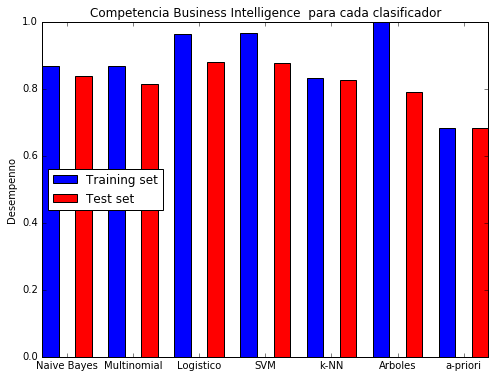

In [43]:
####GRAFICOS-----------------
import matplotlib.pyplot as plt

def graficar_scores(scores,comp):
    title = "Competencia "+ comp + " para cada clasificador"
    colors = ['b','r']*7
    fig, ax = plt.subplots(figsize=(8,6))
    barlist = ax.bar(range(0,14), scores, width  = 0.5, align = "center", color = colors)
    ax.set_ylabel('Desempenno')
    ax.set_title(title)
    ax.set_xticks([0.5,2.5,4.5,6.5,8.5,10.5,12.5])
    ax.set_xticklabels(names+["a-priori"])
    ax.legend( barlist,["Training set","Test set"], loc = 'center left')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()
graficar_scores(scores,lista_skills[j])

En el gráfico anterior se evaluan los distintos clasificadores para predecir la competencia <b>Business Intelligence</b> mediante el análisis del desempeño (precisión) sobre el training set vs el test set. 

Se puede ver que los clasificadores que mejor se comportan basado en tener el mejor desempeño sobre el test set y la menor diferencia entre el desempeño del test set y training set (<i>overfitting</i>) son el Logístico y el SVM, teniendo un desempeño de 88% y 87% respectivamente.

El clasificador que genera un menor <i>overfitting</i> es el de Nearest Neighbors.

### F)

A continuación se repite el procedimiento anterior, prediciendo distintas competencias, ajustando distintos clasificadores para evualarnos y analizar cual se comporta mejor. Las competencias que se predicen son 2 de las más declaradas por los usuarios (Microsoft Excel y HTML), luego 2 elegidas aleatoriamente y finalmente 2 de las menos declaradas por los usuarios (Geoinformatics y Process Scheduler).

Competencia que se predice: Microsoft Excel  (71.000000)
El modelo: Naive Bayes se ha ajustado con accuracy: 0.829914
El modelo: Multinomial se ha ajustado con accuracy: 0.802313
El modelo: Logistico se ha ajustado con accuracy: 0.869079
El modelo: SVM se ha ajustado con accuracy: 0.869452
El modelo: k-NN se ha ajustado con accuracy: 0.836255
El modelo: Arboles se ha ajustado con accuracy: 0.761283


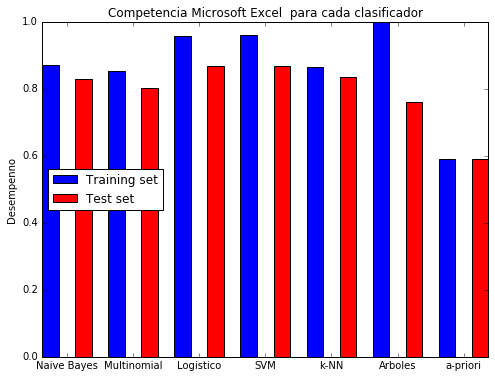

Competencia que se predice: HTML  (44.000000)
El modelo: Naive Bayes se ha ajustado con accuracy: 0.911973
El modelo: Multinomial se ha ajustado con accuracy: 0.874301
El modelo: Logistico se ha ajustado con accuracy: 0.923163
El modelo: SVM se ha ajustado con accuracy: 0.926520
El modelo: k-NN se ha ajustado con accuracy: 0.928758
El modelo: Arboles se ha ajustado con accuracy: 0.903767


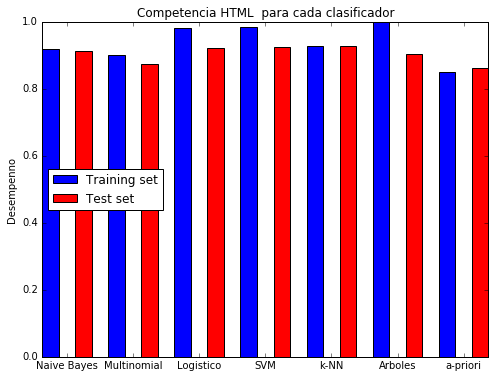

Competencia que se predice: Persona (arquetipo)  (1500.000000)
El modelo: Naive Bayes se ha ajustado con accuracy: 0.998881
El modelo: Multinomial se ha ajustado con accuracy: 0.983215
El modelo: Logistico se ha ajustado con accuracy: 0.998881
El modelo: SVM se ha ajustado con accuracy: 0.998881
El modelo: k-NN se ha ajustado con accuracy: 0.998881
El modelo: Arboles se ha ajustado con accuracy: 0.998135


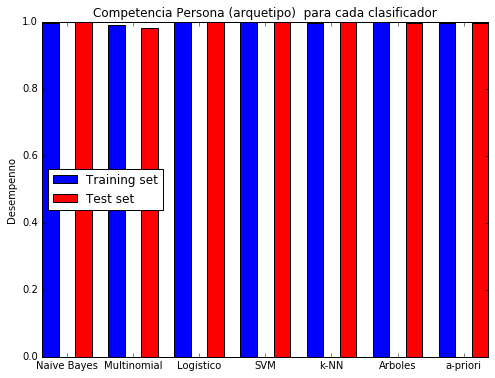

Competencia que se predice: Desarrollo de software  (327.000000)
El modelo: Naive Bayes se ha ajustado con accuracy: 0.911227
El modelo: Multinomial se ha ajustado con accuracy: 0.867214
El modelo: Logistico se ha ajustado con accuracy: 0.947035
El modelo: SVM se ha ajustado con accuracy: 0.948154
El modelo: k-NN se ha ajustado con accuracy: 0.930996
El modelo: Arboles se ha ajustado con accuracy: 0.897053


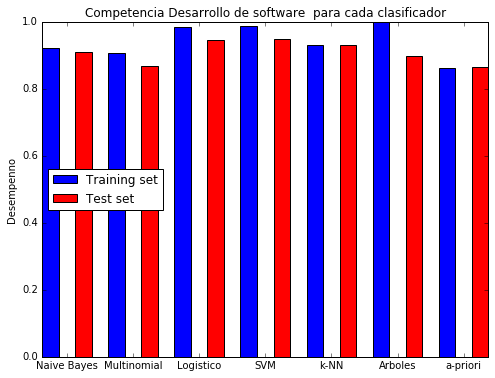

Competencia que se predice: Geoinformatics  (138.000000)
El modelo: Naive Bayes se ha ajustado con accuracy: 0.999627
El modelo: Multinomial se ha ajustado con accuracy: 0.986945
El modelo: Logistico se ha ajustado con accuracy: 0.999627
El modelo: SVM se ha ajustado con accuracy: 0.999627
El modelo: k-NN se ha ajustado con accuracy: 0.999627
El modelo: Arboles se ha ajustado con accuracy: 0.999627


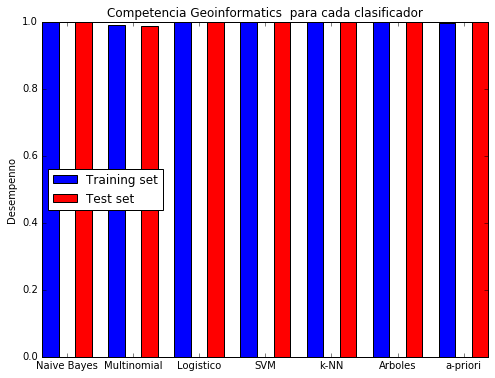

Competencia que se predice: Process Scheduler  (96.000000)
El modelo: Naive Bayes se ha ajustado con accuracy: 0.999627
El modelo: Multinomial se ha ajustado con accuracy: 0.986945
El modelo: Logistico se ha ajustado con accuracy: 0.999627
El modelo: SVM se ha ajustado con accuracy: 0.999627
El modelo: k-NN se ha ajustado con accuracy: 0.999627
El modelo: Arboles se ha ajustado con accuracy: 0.999254


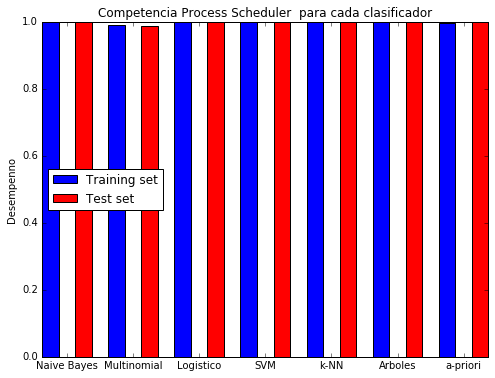

In [47]:
from scipy import sparse
competencias = [71,44, 1500, 327, 138,96] # columna a predecir

for j in competencias:
    print "Competencia que se predice: %s (%f)"%(lista_skills[j],j)
    cols = range(d) #lista de columnas
    cols.remove(j)

    y_tr = Z_tr.getcol(j).toarray().T[0] #target training set
    y_ts = Z_ts.getcol(j).toarray().T[0] #target test set

    X_tr = sparse.lil_matrix(sparse.csr_matrix(Z_tr)[:,cols])
    X_ts = sparse.lil_matrix(sparse.csr_matrix(Z_ts)[:,cols])
    
    scores = make_classification(X_tr,y_tr,X_ts,y_ts)    
    
    graficar_scores(scores, lista_skills[j])

Gracias a estos gráficos se puede ver que para distintas competencias elegidas los clasifiadores que se ajustan mejor basados en su desempeño sobre el test set son el <b>Logístico</b> y el <b>SVM</b>, teniendo el caso en que los datos que se ajustan genernado un menor <i>overfitting</i> son los <b>k-NN</b>, <b>Naive Bayes</b> y <b>Multinomial</b>.

Respecto a la robustez del clasificador basado en el que tiene un comportamiento mas uniforme al momento de predecir distintas competencias son los de <b>Naive Bayes</b> y <b>Multinomial</b>, ya que estos mejoran o empeoran en el desempeño del test set y training set en una razón similar. 

Se tiene que los casos en que los dataset no tienen una cantidad de clases equitativas, es decir el caso en que la competencia es declarada por muy pocos usuarios se produce un sesgo que inclina los datos a predecir que la competencia no sea declarada (un 0 en el target), por lo que la cantidad de clases en el dataset tiene una fuerte influencia en el modelo a predecir ya que este ajusta y entrega un resultado de que el desempeño es bastante bueno (cercano al 100%) lo cual enrealidad está incorrecto, ya que si le entrego de test set unicamente clases que declaran esa competencia el clasificador tendrá desempeño cercano al 0%. Se puede ver que si las clases están inclinadas positiva o negativa (1 o 0 respectivamente), es decir la mayoria de ejemplos del training set se inclinan una etiqueta "1" o "0" sea el caso, se tiene que los datos no son representativos. 

Gracias a este análisis se observa que es recomendable que la cantidad de ejemplos por clase sea equitativa, para obtener un resultado y un clasificador representativo de los datos.